In [1]:
import os
import tqdm

import meep as mp
print(mp.__version__)
import meep.adjoint as mpa
import numpy as np
import autograd.numpy as npa

from matplotlib import pyplot as plt
from icecream import ic

from utils import double_with_mirror, normalise

1.25.0-beta


/home/vincent/mambaforge/envs/meep/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/vincent/mambaforge/envs/meep/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/vincent/mambaforge/envs/meep/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/vincent/mambaforge/envs/meep/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


## Basic environment setup

In [2]:
pml_size = 1.0 # (μm)

In [3]:
dx = 0.02 
opt_size_x = 101 * dx
opt_size_y = 181 * dx
size_x = 2.6 + pml_size # um
size_y = 4.5 + pml_size # um
# size_x = opt_size_x + 2*0.4
# size_y = opt_size_y + 2*0.4
out_wg_dist = 1.25
wg_width = 0.5
mode_width = 3*wg_width
wg_index = 2.8
bg_index = 1.44
wg_zspan = 0.22

# opt_xpixel = opt_size_x*(1/dx)
# opt_ypixel = opt_size_y*(1/dx)

source_wg_xmin = -size_x
source_wg_xmax = -opt_size_x/2 + 0.1
source_wg_y = 0
source_wg_yspan = wg_width
source_wg_z = 0
source_wg_zspan = wg_zspan

top_wg_xmin = opt_size_x/2 - 0.1
top_wg_xmax = size_x
top_wg_y = out_wg_dist
top_wg_yspan = wg_width
top_wg_z = 0
top_wg_zspan = wg_zspan

bot_wg_xmin = top_wg_xmin
bot_wg_xmax = top_wg_xmax
bot_wg_y = -out_wg_dist
bot_wg_yspan = wg_width
bot_wg_z = 0
bot_wg_zspan = wg_zspan

source_x = -size_x/2 - 0.1
source_y = 0
source_yspan = mode_width
source_z = 0
source_zspan = 1
center_wavelength = 1.550

ic(size_x, size_y, opt_size_x, opt_size_y, )

ic| size_x: 3.6, size_y: 5.5, opt_size_x: 2.02, opt_size_y: 3.62


(3.6, 5.5, 2.02, 3.62)

In [4]:
seed = 240
np.random.seed(seed)
mp.verbosity(0)
Si = mp.Medium(index=wg_index) # Effective permittivity for a Silicon waveguide with a thickness of 220nm =2.88
SiO2 = mp.Medium(index=bg_index) # =1.44
delta = dx #(0.02)*ur.micrometers  size of a pixel (in μm) 20 nm in lumerical exp
# resolution = 20 # (pixels/μm)
resolution = 1/delta # pixels/μm
waveguide_width = wg_width #0.5 # (μm)
design_region_width = opt_size_x # (μm)
design_region_height = opt_size_y # (μm)
arm_separation = out_wg_dist #1.0  (μm) distance between arms center to center
waveguide_length = source_wg_xmax - source_wg_xmin #0.5  (μm)
pml_size = 1.0 # (μm)


In [5]:
ic(resolution, waveguide_length, waveguide_width, design_region_height, design_region_width, arm_separation)

ic| resolution: 50.0
    waveguide_length: 2.69
    waveguide_width: 0.5
    design_region_height: 3.62
    design_region_width: 2.02
    arm_separation: 1.25


(50.0, 2.69, 0.5, 3.62, 2.02, 1.25)

## Design variable setup

In [6]:
minimum_length = 0.09 # (μm)
eta_e = 0.75
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length,eta_e) # (μm)
eta_i = 0.5
eta_d = 1-eta_e
design_region_resolution = int(resolution) #int(4*resolution) # (pixels/μm)
frequencies = 1/np.linspace(1.5,1.6,5) # (1/μm)

Nx = int(design_region_resolution*design_region_width)
Ny = int(design_region_resolution*design_region_height)

design_variables = mp.MaterialGrid(mp.Vector3(Nx,Ny),SiO2,Si)
design_region = mpa.DesignRegion(design_variables,
    volume=mp.Volume(center=mp.Vector3(), size=mp.Vector3(design_region_width, design_region_height)))

Nx, Ny

(101, 181)

## Simulation Setup

To have the same polarization as the lumerical experiment (fields have Ex, Ey and Hz components), peterropac on the github discussion suggests to use eig_parity=mp.ODD_Y but the fields have Ez, Hx, Hy components. Yuri thinks we need eig_parity=mp.EVEN_Z. mp.EVEN_Z has the right polarity (fields have Ex, Ey and Hz components) but the fields dont look the same as the lumerical computed fields.

In [7]:
Sx = 2*pml_size + size_x # cell size in X
Sy = 2*pml_size + size_y # cell size in Y
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(pml_size)]

fcen = 1/center_wavelength #1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [source_x, source_y, source_z]
# source_center  = [-Sx/2 + pml_size + waveguide_length/3,0,0]

source_size = mp.Vector3(0,source_yspan, 0) #mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
# src = mp.GaussianSource(frequency=fcen)
source = [mp.EigenModeSource(src,
                            eig_band=1,
                            direction=mp.NO_DIRECTION,
                            eig_kpoint=kpoint,
                            size=source_size,
                            center=source_center,
                            eig_parity=mp.EVEN_Z+mp.ODD_Y)]
mon_pt = mp.Vector3(*source_center)


geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # left waveguide
    mp.Block(center=mp.Vector3(x=Sx/4, y=arm_separation), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # top right waveguide
    mp.Block(center=mp.Vector3(x=Sx/4, y=-arm_separation), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # bottom right waveguide
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables)
]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=SiO2,
                    resolution=resolution)

## Design parameter mapping

In [8]:
def mapping(x,eta,beta):
    # eta in [0,1], skews the distribution towards one material or the other?
    # higher beta makes design more binarized
    x = (npa.fliplr(x.reshape(Nx,Ny)) + x.reshape(Nx,Ny))/2 # up-down symmetry
    # filter
    filtered_field = mpa.conic_filter(x,
        filter_radius,design_region_width,design_region_height,design_region_resolution)
    # projection
    projected_field = mpa.tanh_projection(filtered_field,beta,eta)
    # interpolate to actual materials
    return projected_field.flatten()

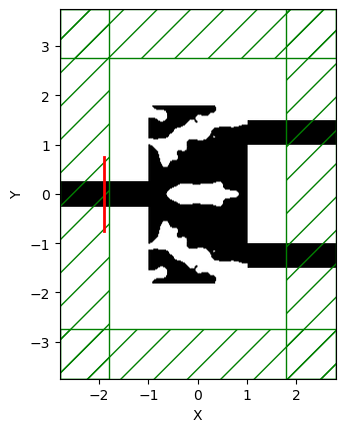

In [9]:
PATH = os.path.expanduser('~/scratch/nanophoto/lowfom/nodata/fields/')
# PATH = os.path.expanduser('~/scratch/nanophoto/highfom/')
image_idx = 1
image = np.load(os.path.join(PATH, 'images.npy'))[image_idx]
idx_map = double_with_mirror(image)
idx_map = normalise(idx_map)
index_map = mapping(idx_map, 0.5, 256)

design_region.update_design_parameters(index_map)

sim.plot2D()
plt.show()

In [10]:
# full field monitor
size = mp.Vector3(Sx, Sy, 0)
dft_monitor = sim.add_dft_fields(
    [mp.Ex, mp.Ey, mp.Ez],             # Components to monitor
    fcen,0,1,
    # frequency=fcen,                     # Operating frequency
    center=mp.Vector3(0, 0, 0),        # Center of the monitor region
    size=size          # Size of the monitor region
)

monsize = mp.Vector3(y=3*waveguide_width)
source_mon_center = mp.Vector3(x=source_x + 0.1)
top_mon_center = mp.Vector3(size_x/2, arm_separation, 0)
source_fluxregion = mp.FluxRegion(center=source_mon_center, size=monsize, weight=-1)
top_fluxregion = mp.FluxRegion(center=top_mon_center, size=monsize, weight=-1)

# flux_box = sim.add_flux(fcen, 0, 1,
#                         mp.FluxRegion(center=mp.Vector3(), size=size))

sim.run(until_after_sources=100)
# sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mon_pt,
#                                                             1e-9))

# # Calculate the field magnitude |E| from the DFT field data
# field_magnitude = np.sqrt(np.abs(ex_data)**2 + np.abs(ey_data)**2 + np.abs(ez_data)**2)

# # Reshape the data for plotting (if necessary)
# field_magnitude = field_magnitude.reshape((int(Sx * resolution), int(Sy * resolution)))

FloatProgress(value=0.0, description='0% done ', max=177.5)

In [11]:
def divise_en_deux(args):
    from math import ceil, floor
    nombres = []
    for x in args:
        nombres += [int(ceil(x/2)), int(floor(x/2))]
    return nombres

ic| meepfx.shape: (280, 375)


(-0.5, 189.5, 204.5, -0.5)

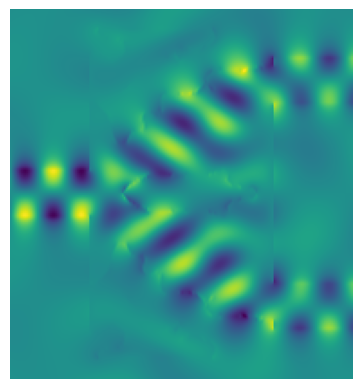

In [13]:
meepfx = sim.get_dft_array(dft_monitor, mp.Ex, 0)
meepfx = np.real(meepfx)
ic(meepfx.shape)
lims = divise_en_deux(np.array(meepfx.shape) - np.array((190,205)))
meepfx = meepfx[lims[0]:-lims[1], lims[2]:-lims[3]].transpose()
plt.imshow(meepfx)
plt.axis('off')

<Axes: xlabel='X', ylabel='Y'>

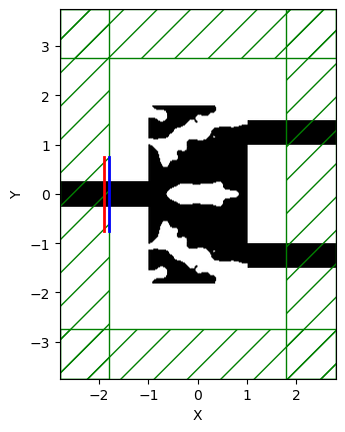

In [14]:
def get_sim_coeffs_from_flux_region(sim, fluxregion):
    sim.reset_meep()
    flux = sim.add_flux(fcen, 0, 1, fluxregion)
    # breakpoint()
    mon_pt = mp.Vector3(*source_center)
    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mon_pt,
                                                            1e-9))
    res = sim.get_eigenmode_coefficients(flux, [1])#,
                                        #  eig_parity=mp.ODD_Z + mp.EVEN_Y)
    coeffs = res.alpha
    accumulated_flux_spectrum = mp.get_fluxes(flux)
    return coeffs, accumulated_flux_spectrum


# Get incident flux coefficients
# source_center = [-Sx/2 + pml_size + waveguide_length/3, 0, 0]
source_mon_pt = mp.Vector3(x=source_x + 0.1)
monsize = mp.Vector3(y=3*waveguide_width)
source_fluxregion = mp.FluxRegion(center=source_mon_pt, size=monsize)
source_coeffs, source_flux_spectrum = get_sim_coeffs_from_flux_region(sim, source_fluxregion)
sim.plot2D()

<Axes: xlabel='X', ylabel='Y'>

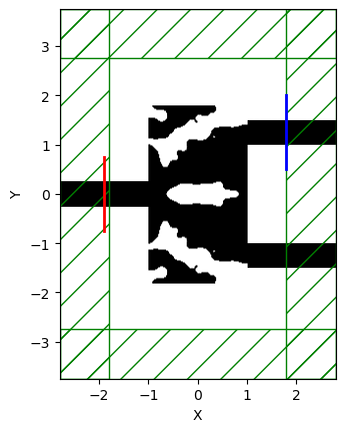

In [15]:
# Get top output flux coefficients
topmoncenter = mp.Vector3(size_x/2, arm_separation, 0)
topfluxregion = mp.FluxRegion(topmoncenter, monsize)
top_coeffs, top_flux_spectrum = get_sim_coeffs_from_flux_region(sim, topfluxregion)
sim.plot2D()

<Axes: xlabel='X', ylabel='Y'>

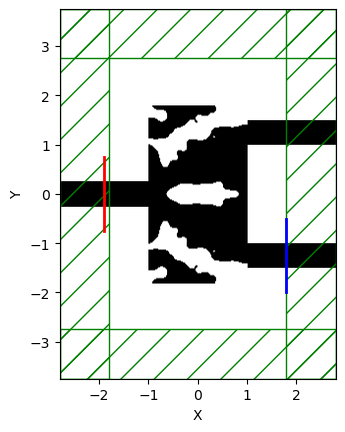

In [42]:
# # Get bot output flux coeffs
# botmoncenter = mp.Vector3(size_x/2, -arm_separation, 0)
# botfluxregion = mp.FluxRegion(botmoncenter, monsize)
# bot_mon = sim.add_mode_monitor(fcen, 0, 1, botfluxregion)
# bot_coeffs, bot_flux_spectrum = get_sim_coeffs_from_flux_region(sim, botfluxregion)
# sim.plot2D()

In [40]:
top_coeff = top_coeffs[0,0,1]
source_coeff = source_coeffs[0,0,0]
# bot_coeff = bot_coeffs[0,0,1]
Jt = np.abs(top_coeff)**2/np.abs(source_coeff)**2
# Jb = abs(bot_coeff/source_coeff)**2
# FOM1 = Jt + Jb
FOM1 = Jt
# Ce FOM a un max de 1 plutot que 0.5 comme dans Lumerical. Il faudrait 
# prendre un seul des bras de sortie a monitorer.
FOM1

0.00035120900328613244

In [44]:
ic(np.abs(top_coeffs))
ic(np.abs(source_coeffs))

ic| np.abs(top_coeffs): array([[[4.97622091, 0.14256336]]])
ic| np.abs(source_coeffs): array([[[7.60720465, 0.7668212 ]]])


array([[[7.60720465, 0.7668212 ]]])

In [46]:
np.abs(top_coeffs[0,0,1]/source_coeffs[0,0,0])

0.018740571050160998

In [18]:
FOM2 = (top_flux_spectrum[0])/source_flux_spectrum[0] 
FOM2

0.45623481979019137

In [19]:
np.load(os.path.join(PATH, 'fom.npy'))[image_idx]

0.42187603818409114

In [21]:
#debugging
import os
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
PATH = '~/scratch/nanophoto/lowfom/nodata/fields'
PATH = os.path.expanduser(PATH)

ic| f0.min(): -0.6147139150878218, f0.max(): 0.6147139150878218
ic| f1.min(): -0.5862201920114011, f1.max(): 0.5862201920114011
ic| f0.min(): -1.0657774119307353, f0.max(): 1.299933493997433
ic| f1.min(): -0.9230115798233446, f1.max(): 1.1151629425060283
ic| f0.min(): 0.0, f0.max(): 0.0
ic| f1.min(): 0.0, f1.max(): 0.0


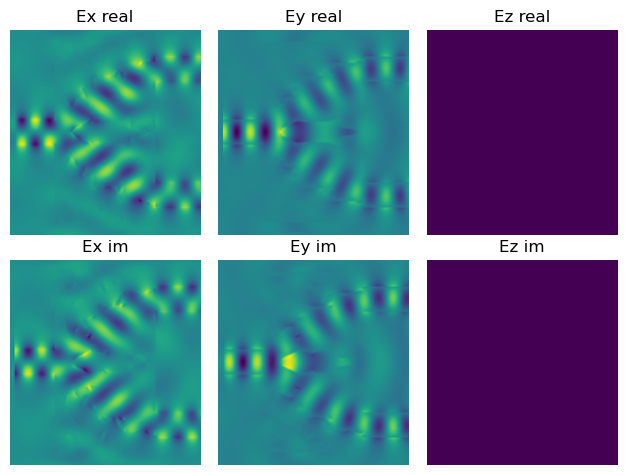

In [22]:
field = np.load(os.path.join(PATH, 'fields.npy'), mmap_mode='r')[image_idx]
names = ['Ex', 'Ey', 'Ez']
_, axes = plt.subplots(2,len(names))
for i, name in enumerate(names):
    f0 = np.real(field[...,i])
    f1 = np.imag(field[...,i])
    axes[0,i].imshow(f0.transpose())
    axes[0,i].set_title(f'{name} real')
    axes[0,i].axis('off')
    axes[1,i].imshow(f1.transpose())
    axes[1,i].axis('off')
    axes[1,i].set_title(f'{name} im')
    ic(f0.min(), f0.max())
    ic(f1.min(), f1.max())
plt.tight_layout()
plt.show()

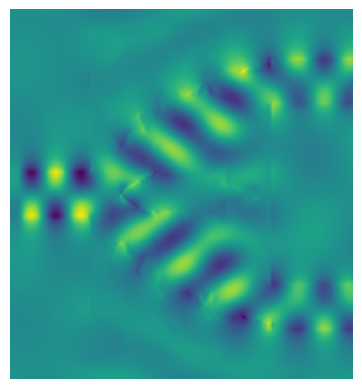

In [23]:
lumfx = np.real(field[:,:,0].transpose())
plt.imshow(lumfx)
plt.axis('off')
plt.show()

In [24]:
def npstats(arr):
    print('mean', np.mean(arr))
    print('std', np.std(arr))
    print('min', np.min(arr))
    print('max', np.max(arr))

In [28]:
lsource = lumfx[ 50:150, :75]
msource = meepfx[ 50:150, :75]

npstats(lumfx)
npstats(meepfx)

mean -1.5962128210271828e-19
std 0.1342141913096955
min -0.6147139150878218
max 0.6147139150878218
mean 0.0003141524163193549
std 1.0735710006349344
min -4.554505620521965
max 4.557542963568196


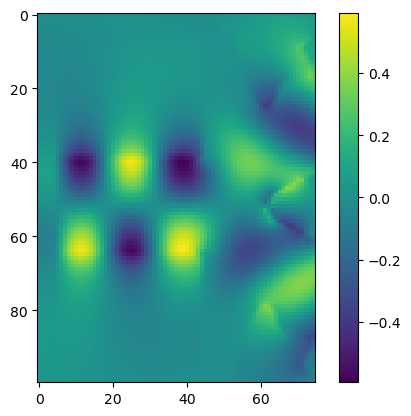

ic| lsource.max(): 0.5936285991896606


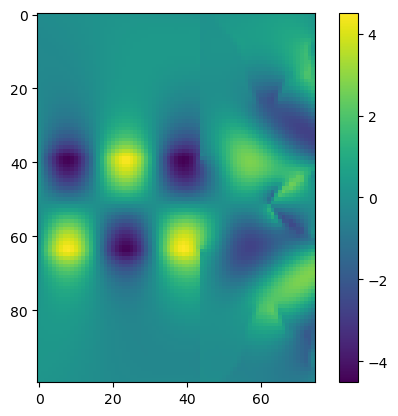

ic| msource.max(): 4.511621789254102


4.511621789254102

In [29]:

plt.imshow(lsource)
plt.colorbar()
plt.show()
ic(lsource.max())

plt.imshow(msource)
plt.colorbar()
plt.show()
ic(msource.max())



In [30]:
4.511621789254102/0.5936285991896606

7.600074853894745

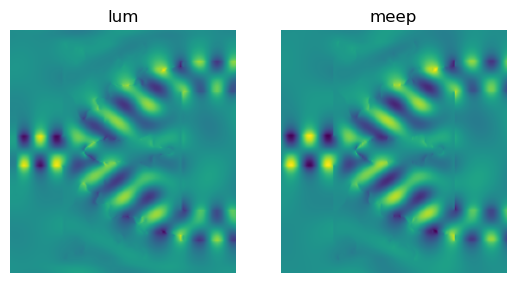

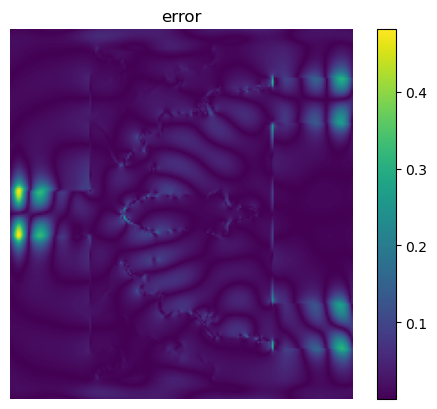

ic| np.abs(lumfx - meepfx/7.6).sum()/(190*205): 0.025958384639259303


0.025958384639259303

In [31]:
_, axes = plt.subplots(1,2)
axes[0].imshow(lumfx)
axes[0].axis('off')
axes[0].set_title('lum')
axes[1].imshow(meepfx)
axes[1].axis('off')
axes[1].set_title('meep')
plt.show()
plt.imshow(np.abs(lumfx - meepfx/7.6))
plt.axis('off')
plt.title('error')
plt.colorbar()
plt.show()
ic(np.abs(lumfx - meepfx/7.6).sum()/(190*205))

FloatProgress(value=0.0, description='0% done ')

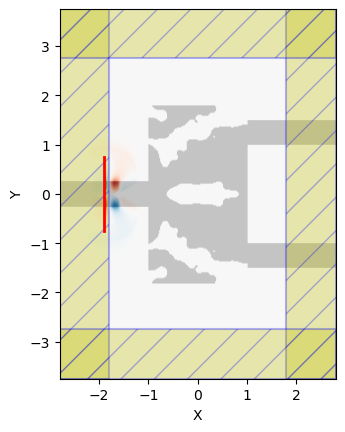

In [32]:
sim.reset_meep()
animate = mp.Animate2D(fields=mp.Ex,
                       realtime=True,
                       normalize=True,
                       field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'none'},
                       boundary_parameters={'linewidth':1.5, 'facecolor':'y', 'edgecolor':'b', 'alpha':0.3})

sim.run(mp.at_every(1,animate),until=100)
animate.to_mp4(fps=24, filename='anim.mp4')